In [10]:
from qdrant_client import QdrantClient
import numpy as np

COLLECTION_NAME = "faces"
client = QdrantClient("http://192.168.0.12:6333")

all_vectors = []
all_payloads = []

scroll_offset = None

while True:
    points, scroll_offset = client.scroll(
        collection_name=COLLECTION_NAME,
        limit=1000,
        offset=scroll_offset,
        with_vectors=True,
        with_payload=True
    )

    if not points:
        break

    for p in points:
        all_vectors.append(p.vector)
        all_payloads.append(p.payload)

    if scroll_offset is None:
        break

print("Загружено лиц:", len(all_vectors))

Загружено лиц: 761


In [11]:
from sklearn.cluster import DBSCAN

vectors_np = np.array(all_vectors)

clustering = DBSCAN(
    eps=0.6,              # можно регулировать (0.3–0.6)
    min_samples=2,
    metric="cosine"
).fit(vectors_np)

labels = clustering.labels_

print("Найдено кластеров:", len(set(labels)) - (1 if -1 in labels else 0))

Найдено кластеров: 8


In [14]:
from collections import defaultdict

clusters = defaultdict(list)

for idx, label in enumerate(labels):
    if label != -1:
        clusters[label].append(all_payloads[idx])

# быстрая проверка
first_cluster = next(iter(clusters))
print("Пример элемента кластера:", type(clusters[first_cluster][0]), clusters[first_cluster][0].keys())

Пример элемента кластера: <class 'dict'> dict_keys(['photo_path', 'bbox'])


In [21]:
import matplotlib.pyplot as plt
import cv2
import random

def show_cluster_examples(cluster_id, num_examples=5):
    items = clusters[cluster_id]
    samples = random.sample(items, min(num_examples, len(items)))

    plt.figure(figsize=(4 * len(samples), 4))

    for i, item in enumerate(samples):
        path = item["photo_path"]
        x1, y1, x2, y2 = map(int, item["bbox"])

        img = cv2.imread(path)
        if img is None:
            print("Не удалось прочитать:", path)
            continue

        h, w = img.shape[:2]

        # защитимся от выхода bbox за границы
        x1 = max(0, min(x1, w - 1))
        x2 = max(0, min(x2, w - 1))
        y1 = max(0, min(y1, h - 1))
        y2 = max(0, min(y2, h - 1))

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 255), 16)  # красный в BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = plt.subplot(1, len(samples), i + 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Cluster {cluster_id}")

    plt.show()


Кластер 0, всего лиц: 90


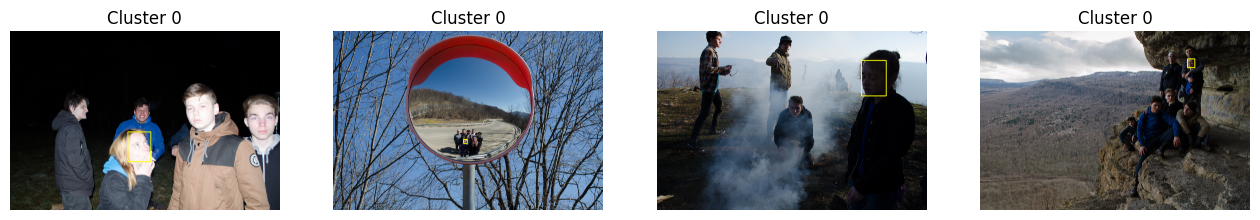


Кластер 1, всего лиц: 102


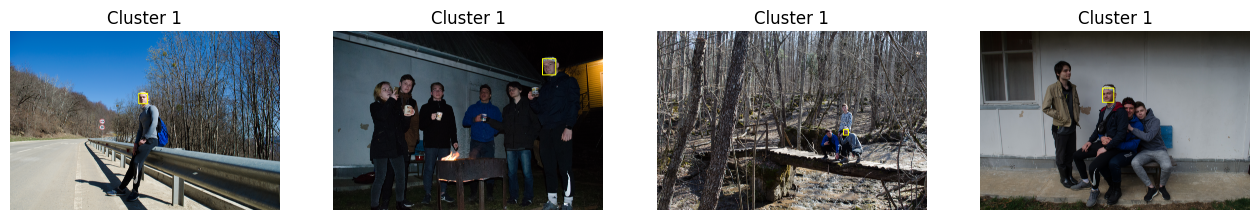


Кластер 2, всего лиц: 96


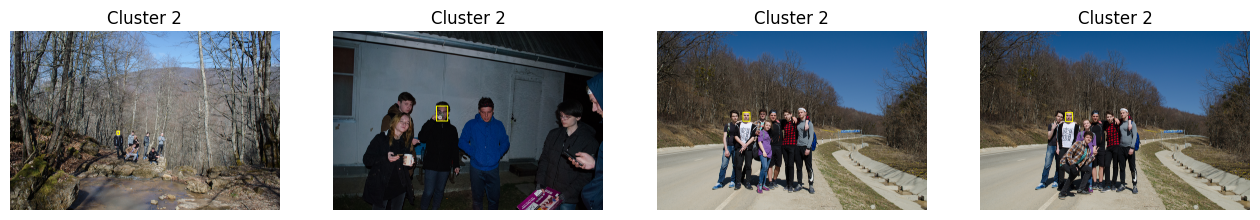

In [23]:
for cluster_id in list(clusters.keys())[:3]:
    print(f"\nКластер {cluster_id}, всего лиц:", len(clusters[cluster_id]))
    show_cluster_examples(cluster_id, num_examples=4
    )